# notebook minist and different optimizers

the basis is kaiminig optimization and batchnorm

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import torch
from torch import *

#let me be on my mac
def cuda(self, device=None, non_blocking=False) : return self
torch.Tensor.cuda = cuda

In [3]:
from lib.modelmanager import *
from lib.model import *
from lib.data import *
from lib.optimizers import *
from lib.callbacks import *
from lib.graphics import *
from pathlib import Path
from PIL import Image

## mnist data

In [4]:
#mnist_path = Path("C:/Users/kl/.fastai/data/mnist.pkl.gz")
mnist_path = Path("/Users/kasparlund/.fastai/data/mnist.pkl.gz")
x_train,y_train,x_valid,y_valid = load_pickled_train_valid_data(mnist_path)
train_mean, train_sd = x_train.mean(), x_train.std()
x_train   = normalize( x_train, train_mean, train_sd)
x_valid   = normalize( x_valid, train_mean, train_sd)

x_train.mean(),x_train.std()

(tensor(-7.6999e-06), tensor(1.))

In [5]:
nh,bs              = 50,128 #512
train_ds,valid_ds  = Dataset(x_train, y_train),Dataset(x_valid, y_valid)
train_dl, valid_dl = ( DataLoader( train_ds, batch_size=bs, shuffle=True), 
                        DataLoader(valid_ds,  batch_size=512) )
#                        DataLoader(valid_ds,  batch_size=bs*2) )
data               = DataBunch( train_dl, valid_dl, c_in=1, c_out=y_train.max().item()+1 )
xb, _              = next(iter(train_dl))
print(len(train_dl)), print(len(valid_dl))

391
20


(None, None)

## Adam: steppers=[adam_step]

In [6]:
mnist_view   = view_tfm(1,28,28)
layers_sizes = [8,16,32,32]
loss_func    = F.cross_entropy
sched        = combine_scheds([0.3, 0.7], [sched_cos(0.3, 0.6), sched_cos(0.6, 0.2)]) 

cbfs         = [TrainableModelCallback, TrainEvalCallback, OptimizerCallback, 
#                partial(CudaCallback, device= torch.device('cuda',0)),
#                partial(ParamScheduler, 'lr', sched),
                partial(BatchTransformXCallback, tfm = mnist_view), 
#                partial(MixUp,α=0.4),
#                LR_Finder,
                Recorder, 
                partial(AvgStatsCallback,[accuracy]),
                ProgressCallback
               ]



In [7]:
#get the next image array an convert it to a 2d image
tensor   = mnist_view(next(iter(train_dl))[0][0]).squeeze()
np_image = denormalize(tensor, train_mean, train_sd).numpy()
print(f"train_mean:{train_mean} train_sd:{train_sd} np_image.shape:{np_image.shape}")
img = Image.fromarray( np.uint8(np_image*255) ).convert("RGB")
img

train_mean:0.13044971227645874 train_sd:0.30728983879089355 np_image.shape:(28, 28)


In [8]:
class RReLUOffset(torch.nn.ReLU):
    def __init__(self, post_relu_offset = 0.15, random_range=0.1 ): #0.15915):
        super().__init__(inplace=True)
        self.register_buffer("offset",torch.tensor(post_relu_offset, dtype=torch.float32))
        self.register_buffer("random_range",torch.tensor(random_range, dtype=torch.float32))
        self.register_buffer("central_noise",torch.tensor(post_relu_offset, dtype=torch.float32))
        
    def forward(self, x):
        if self.training:
            if not self.central_noise.size() == x.size():
                self.central_noise = torch.zeros_like(x[0,:], dtype=torch.float32, requires_grad=False)
            #nn.init.uniform_(self.central_noise, (self.offset-self.random_range).item(),(self.offset+self.random_range).item()) 
            #x = super().forward(x+self.central_noise) - self.central_noise
            nn.init.uniform_(self.central_noise, (-self.random_range).item(),(self.random_range).item()) 
            x = super().forward(x+self.offset+self.central_noise) - self.offset
        else:
            #x = super().forward(x+self.central_noise) - self.central_noise
            x = super().forward(x+self.offset) - self.offset
        
        return x

class RLeakyReLU(torch.nn.LeakyReLU):
    def __init__(self, negative_slope=0.22, random_range=0.1 ): #0.15915):
        super().__init__(negative_slope=negative_slope, inplace=True)
        self.register_buffer("random_range",torch.tensor(random_range, dtype=torch.float32))
        self.register_buffer("central_noise",torch.tensor(0, dtype=torch.float32))
        
    def forward(self, x):
        if self.training:
            if not self.central_noise.size() == x.size():
                self.central_noise = torch.zeros_like(x[0,:], dtype=torch.float32, requires_grad=False)
            nn.init.uniform_(self.central_noise, (-self.random_range).item(),(self.random_range).item()) 
            x = super().forward(x+self.central_noise)
        else:
            x = super().forward(x)
        
        return x

activ_func = partial(RReLUOffset,post_relu_offset = 0.15, random_range=0.15)
#activ_func = partial(RReLUOffset,post_relu_offset = 0.10, random_range=0.1)
#activ_func = partial(nn.SELU,inplace=True)
#activ_func = nn.CELU
#activ_func = partial(nn.RReLU,inplace=True)
#activ_func = partial(nn.PReLU,num_parameters=1, init=0.25) 
#activ_func = partial(RLeakyReLU,negative_slope=0.22, random_range=0.1) 
#activ_func = partial(nn.LeakyReLU,negative_slope=0.22) 
#activ_func = partial(nn.ReLU,inplace=True)
model = partial(xresnet18, c_in=data.c_in, c_out=data.c_out, activ_func=activ_func)()
#model = get_cnn_model(layers_sizes, data.c_in, data.c_out, layer=layer)
mm    = CnnModelManager( model )
#mm.initialize(is_resnet=True, a=0, nonlinearity="relu") #leaky_relu
#mm.initialize(is_resnet=True, a=0.015, nonlinearity="leaky_relu")
mm.initialize(is_resnet=True, a=1e-2, nonlinearity="leaky_relu")

#opt   = Adam(sched,max_lr=3e-3, moms=(0.9,0.95), max_wd = 0)#1e-5)#1e-6)
#opt   = Adam(sched,max_lr=8e-3, moms=(0.85,0.95), max_wd = 0)#1e-5)#1e-6)
opt   = Adam(sched,max_lr=5e-3, moms=(0.85,0.95), max_wd = 0)#1e-5)#1e-6)
#opt   = Adam(sched,max_lr=1e-3, moms=(0.85,0.95), max_wd = 0)#1e-5)#1e-6)
learn = Learner( mm.model, data, loss_func=F.cross_entropy)
%time learn.fit(5, opt=opt, cb_funcs=cbfs)
#%time learn.fit(1, opt=opt, cb_funcs=cbfs.copy()+[partial(MixUp,α=0.2)])#α=0.025)])
#%time learn.fit(5, opt=opt, cb_funcs=cbfs.copy()+[partial(MixUp,α=0.2),LRFinder])
#%time learn.fit(1, opt=opt, cb_funcs=cbfs.copy()+[LRFinder])


epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,0.266609,0.920720,0.123571,0.960600,01:45
1,0.088754,0.973360,0.067133,0.979700,01:43
2,0.063216,0.979420,0.061684,0.982900,01:43
3,0.043864,0.986040,0.047862,0.986200,01:42
4,0.032047,0.990180,0.040221,0.989300,01:42


CPU times: user 47min 40s, sys: 9min 47s, total: 57min 27s
Wall time: 8min 37s


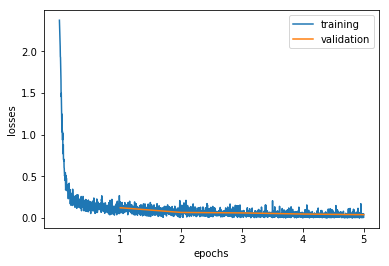

(None, None)

In [9]:
learn.find_subcription_by_cls(Recorder).plot_loss(),plt.show()
#learn.find_subcription_by_cls(LRFinder).plot_loss(skip_end=2),plt.show()
#mm.summary(mnist_view(xb))